In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import math

import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
attack_focus = 'ref-stablelm-base-alpha-3b-v2'

In [3]:
with open(f"./niloofar/results_for_niloofar/stable_lm_ref/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-wikipedia_(en)_ngram_13_<0.8_truncated/{attack_focus}_results.json", 'r') as f:
    og_data = json.load(f)

member_scores = og_data['predictions']['member']
nonmember_scores = og_data['predictions']['nonmember']

In [4]:
og_data['predictions'].keys()

dict_keys(['nonmember', 'member'])

In [5]:
def filter_out_nan(x):
    return [element for element in x if not math.isnan(element)]

In [6]:
def get_auc_from_thresholds(preds_member, preds_nonmember):
    """
    Compute FPRs and TPRs corresponding to given thresholds
    """
    tpr, fpr = [], []
    for threshold in thresholds:
        tp = np.sum(preds_member >= threshold)
        tn = np.sum(preds_nonmember < threshold)
        fp = np.sum(preds_nonmember >= threshold)
        fn = np.sum(preds_member < threshold)

        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    
    tpr = np.array(tpr)
    fpr = np.array(fpr)
    return auc(fpr, tpr)

In [19]:
preds_member_ = -np.array(member_scores)
preds_nonmember_ = -np.array(nonmember_scores)
total_preds = np.concatenate((preds_member_ , preds_nonmember_))

total_labels = [1] * len(preds_member_) + [0] * len(preds_nonmember_)
fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)

In [20]:
roc_auc

0.578991

In [9]:
get_auc_from_thresholds(preds_member_, preds_nonmember_)

0.578991

In [10]:
with open("./newmia_results_all/wikipedia_(en).json", 'r') as f:
    d = json.load(f)

In [11]:
care = d[attack_focus]

## Consider edited-members as members

In [12]:
columns = ['edit distance', 'AUC']
raw_data = []
raw_data.append((0, roc_auc))

for n, v in care.items():
    for score in v.values():
        pm = -np.array(score)
        raw_data.append((int(n), get_auc_from_thresholds(pm, preds_nonmember_)))

In [ ]:
df = pd.DataFrame(raw_data, columns=columns)

In [ ]:
sns.lineplot(data=df, x='edit distance', y='AUC', markers=True, dashes=False)

In [ ]:
df.groupby('edit distance').mean()

### Consider edited-members as non-members

In [25]:
columns = ['edit distance', 'AUC']
raw_data = []
raw_data.append((0, 0.5))

for n, v in care.items():
    for score in v.values():
        # Consider "members" as members
        preds_member_ = -np.array(member_scores)
        # And edited members as "non members"
        preds_nonmember_ = -np.array(score)
        total_preds = np.concatenate((preds_member_ , preds_nonmember_))

        total_labels = [1] * len(preds_member_) + [0] * len(preds_nonmember_)
        fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
        roc_auc = auc(fpr, tpr)
        
        raw_data.append((int(n), roc_auc))

In [26]:
df = pd.DataFrame(raw_data, columns=columns)

<AxesSubplot: xlabel='edit distance', ylabel='AUC'>

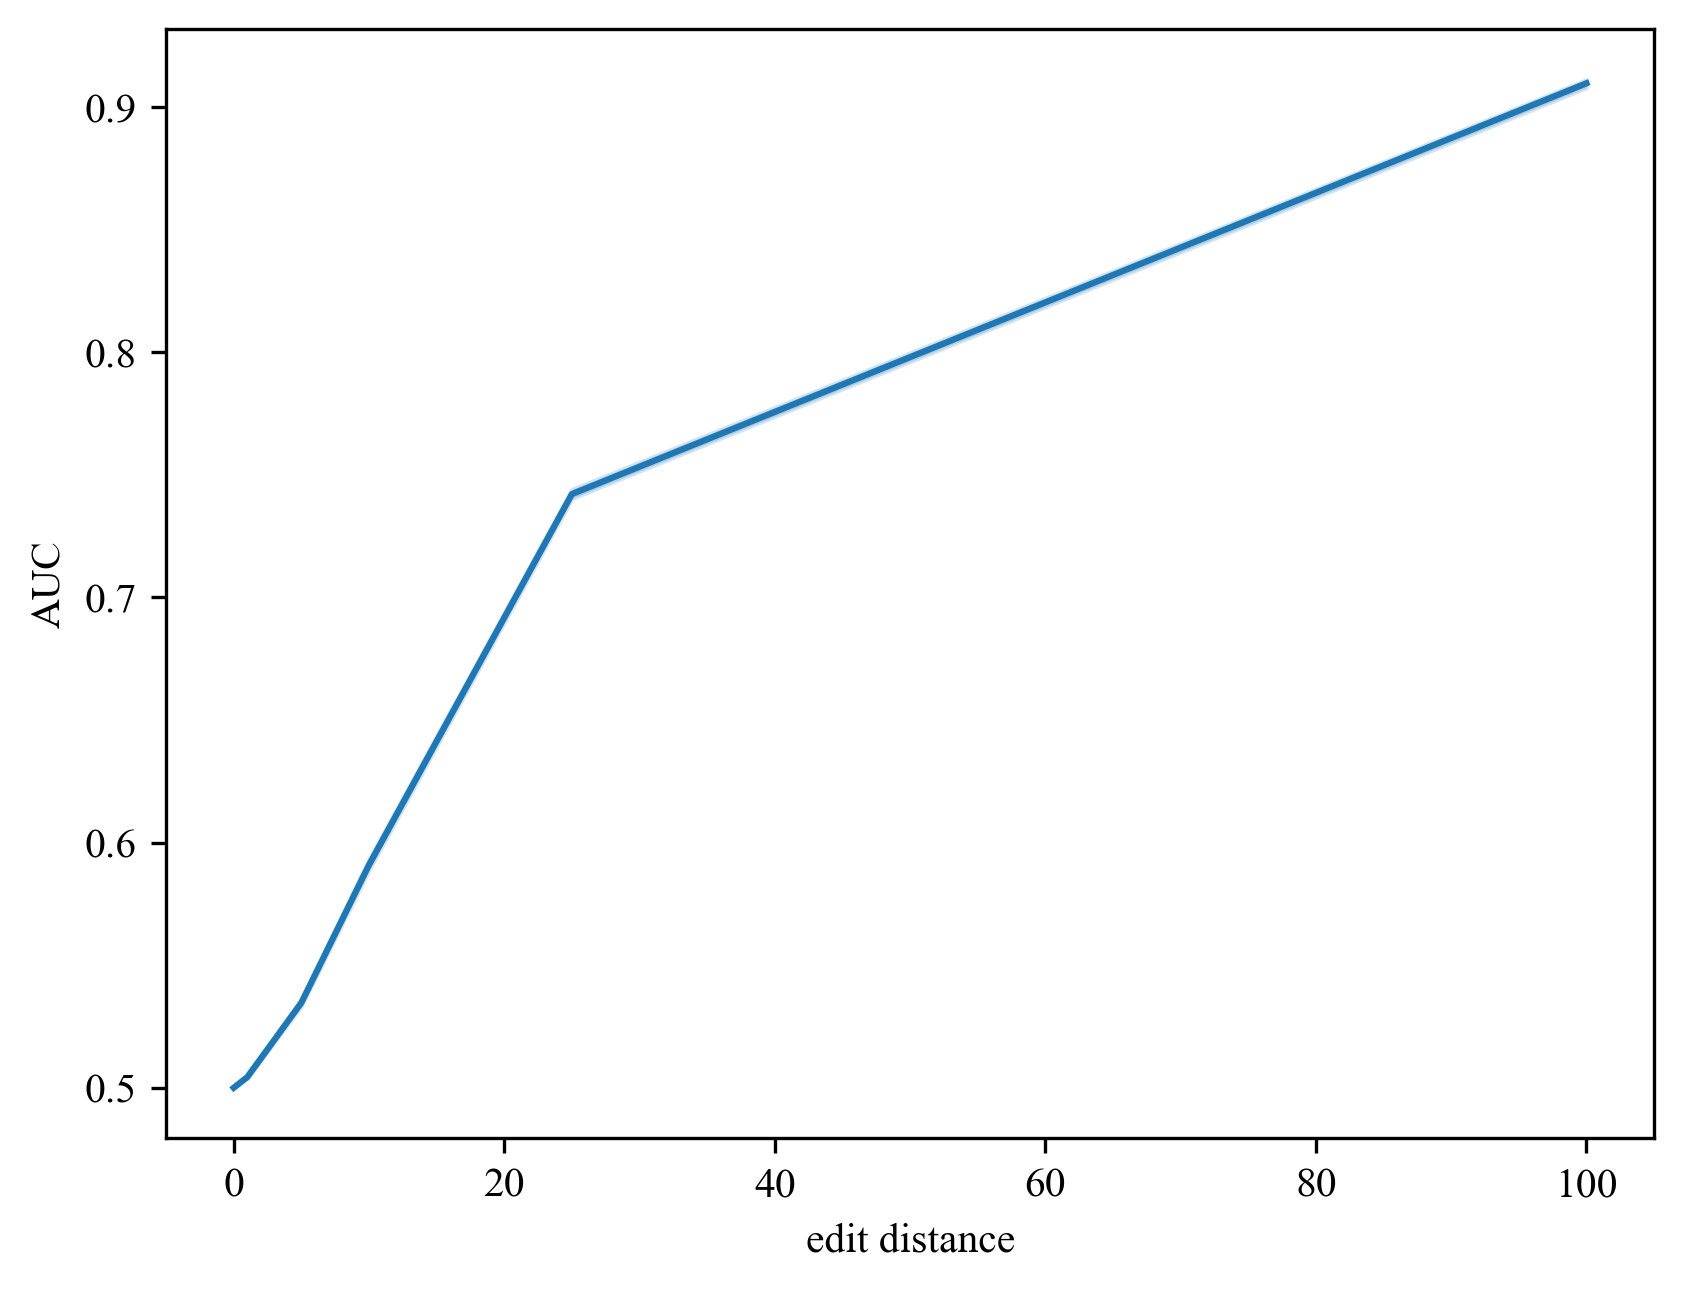

In [27]:
sns.lineplot(data=df, x='edit distance', y='AUC', markers=True, dashes=False)

In [28]:
df.groupby('edit distance').mean()

,AUC
edit distance,
0,0.500000
1,0.504326
5,0.534676
10,0.590877
25,0.742131
100,0.909689
